In [55]:
# https://papers.nips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf

import torch 
import torch.nn as nn
import torch.nn.functional as F
import torchvision 
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
%matplotlib inline

In [56]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [70]:
transform = transforms.Compose(
    [transforms.ToTensor(), 
     transforms.Resize((227,227)),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


# already downloaded
train = torchvision.datasets.CIFAR10(root='./data/train_CIFAR10', train=True,
                                    download=False, transform=transform)

train_loader = torch.utils.data.DataLoader(train, batch_size=64,
                                          shuffle=True, num_workers=2)
# already downloaded 
test = torchvision.datasets.CIFAR10(root='./data/test_CIFAR10', train=False,
                                    download=False, transform=transform)

test_loader = torch.utils.data.DataLoader(train, batch_size=64,
                                          shuffle=True, num_workers=2)

In [71]:
classes = train.classes
itos = {i:s for i, s in enumerate(classes)}
train.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

Image:ship,
size: torch.Size([3, 227, 227])


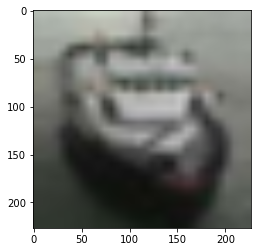

In [72]:
def image_look(index): 
    image, label = train[index]
    print(f'Image:{itos[label]},\nsize: {image.shape}')
    # chatGPT code to make it look better
    # Convert the tensor to a numpy array and undo the normalization
    image = image.cpu().numpy().transpose((1, 2, 0))
    image = (image / 2.0) + 0.5

    # Display the image
    plt.imshow(image)
    plt.show()
image_look(170)
    

In [73]:
class AlexNet(nn.Module): 
    def __init__(self, num_classes=10): 
        super(AlexNet, self).__init__()
        
        self.l1 = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),
            nn.LocalResponseNorm(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2))
        
        self.l2 = nn.Sequential(
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            nn.LocalResponseNorm(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2))
        
        self.l3 = nn.Sequential(
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1), 
            nn.LocalResponseNorm(384),
            nn.ReLU())
        
        self.l4 = nn.Sequential(
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.LocalResponseNorm(384),
            nn.ReLU())
        
        self.l5 = nn.Sequential(
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.LocalResponseNorm(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2))
        
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5), 
            nn.Linear(in_features=9216, out_features=4096), 
            nn.ReLU(), 
            nn.Dropout(p=0.5), 
            nn.Linear(in_features=4096, out_features=num_classes))
        
    def forward(self, x): 
        out = self.l1(x)
        out = self.l2(out)
        out = self.l3(out)
        out = self.l4(out)
        out = self.l5(out)
        out = out.reshape(out.size(0), -1)
        out = self.classifier(out) 
        return out



In [74]:
# training loop 
torch.manual_seed(423984) 
alexnet = AlexNet(10)
alexnet.to(device)

loss_fn = nn.CrossEntropyLoss()
# optimizer parameters according to paper
optimizer = torch.optim.SGD(alexnet.parameters(),lr=0.01, momentum=0.9, weight_decay=0.0005)

In [76]:
# my copmputer is too slow to run this :(((( as i dont have access to a GPU

from tqdm.auto import tqdm 

torch.manual_seed(424)

epochs = 5

for epoch in tqdm(range(epochs)):
    print(f'Epoch: {epoch}\n-----')
    
    train_loss = 0
    
    for batch, (x, y) in enumerate(train_loader): 
        x = x.to(device)
        
        y_pred = alexnet(x)
        
        loss = loss_fn(y_pred, y)
        train_loss += loss
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    train_loss /= len(train)
    
    test_loss = 0
    
    with torch.inference_mode(): 
        for x, y in test:
            test_pred = alexnet(x) 
            
            loss = loss_fn(test_pred, y)
            test_loss += loss
            
        test_loss /= len(test)
    
    print(f"\nTrain loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n")

    

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0
-----


/Users/finhardy/opt/anaconda3/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/finhardy/opt/anaconda3/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  Referenced from: <F30FD7F2-B214-3D4A-93DD-0D484FBE6931> /Users/finhardy/opt/anaconda3/lib/python3.9/site-packages/torchvision/image.so
  Expected in:     <9D4C7FD2-49A8-383A-AC3E-A560DE81B0D8> /Users/finhardy/opt/anaconda3/lib/python3.9/site-packages/torch/lib/libtorch_cpu.dylib
  warn(f"Failed to load image Python extension: {e}")
/Users/finhardy/opt/anaconda3/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/finhardy/opt/anaconda3/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Symbol not foun

KeyboardInterrupt: 